In [1]:
## knuckleball effect



In [94]:
#!/usr/bin/python
from scipy.integrate import odeint
import matplotlib.pyplot as plt # for plotting          
import numpy as np
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

class Particle(object):

    """Class that describes particle"""
    m = 1.0

    def __init__(self, x0=0.0, y0 =0.0, z0= 0.2, u0=0.0, v0 = 0.0, w0 = 0.0,  tf = 10.0, dt = 0.01, goalX = 40):
        # print("particle init'd")
        self.x = np.array([x0,y0,z0])
        self.v = np.array([u0,v0,w0])
        self.t = 0.0
        self.tf = tf
        self.dt = dt
        npoints = int(tf/dt) # always starting at t = 0.0
        self.npoints = npoints
        self.tarray = np.linspace(0.0, tf,npoints, endpoint = True) # include final timepoint
        self.xv0 = np.ravel(np.array([self.x, self.v])) # NumPy array with initial position and velocity
        self.Forces = []  #storing list of forces for analysis purposes 
        self.accel = []  #storing list of accelerations for analysis purposes (updated in RK4step)
        self.indGoal = None
        self.goal = goalX
        self.indGround = None

    def reinitialize(self):
        self.npoints = int(self.tf/self.dt)
        self.x = self.xv0[0:3]
        self.v = self.xv0[3:]
        self.t = 0

    
    def F(self, x, v, t):
        return np.array([0.0, 0.0, 0.0])

    def Euler_step(self): # increment position as before
        a = self.F(self.x, self.v, self.t) / self.m
        self.x += self.v * self.dt
        self.v += a * self.dt
        self.t += self.dt
    
    def RK4_step(self):
        a1 = self.F(self.x, self.v, self.t) / self.m
        
        k1 = np.array([self.v, a1])*self.dt

        a2 = self.F(self.x+k1[0]/2, self.v+k1[1]/2, self.t+self.dt/2) / self.m
        k2 = np.array([self.v+k1[1]/2 ,a2])*self.dt
        
        a3 = self.F(self.x+k2[0]/2, self.v+k2[1]/2, self.t+self.dt/2) / self.m
        k3 = np.array([self.v+k2[1]/2, a3])*self.dt
        
        a4 = self.F(self.x+k3[0], self.v+k3[1], self.t+self.dt) / self.m
        k4 = np.array([self.v+k3[1], a4])*self.dt

        self.x += (k1[0]+ k4[0])/6 + (k2[0] + k3[0])/3
        self.v += (k1[1]+ k4[1])/6 + (k2[1] + k3[1])/3
        
        self.Forces.append(self.F(self.x, self.v, self.t))
        accelWithTime = np.append(a1,self.t)
        self.accel.append(accelWithTime)
        
        if (self.indGoal == None):
            if(self.x[0]>self.goal):
                self.indGoal = int(self.t/self.dt)
                
        if (self.indGround == None):
            if(self.x[2]<0.1):
                self.indGround = int(self.t/self.dt)
        
        self.t += self.dt

    def Euler_trajectory(self):  # calculate trajectory as before
        # will reinitialize euler trajectory everytime this method is called
        x_euler = np.zeros([self.npoints, 3])
        v_euler = np.zeros([self.npoints, 3])

        for ii in range(self.npoints):
            x_euler[ii] = self.x
            v_euler[ii] = self.v
            self.Euler_step()
        
        self.x_euler = x_euler
        self.v_euler = v_euler
    
    def RK4_trajectory(self):  # calculate trajectory as before
        # need to reinitialize if you want to call this method and others
        x_RK4 = np.zeros([self.npoints, 3])
        v_RK4 = np.zeros([self.npoints, 3])
        
        for ii in range(self.npoints):
            x_RK4[ii] = self.x
            v_RK4[ii] = self.v
            self.RK4_step()

        self.x_RK4 = x_RK4
        self.v_RK4 = v_RK4

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.xv = odeint(self.derivative, self.xv0, self.tarray)

    def derivative(self, xv, t):
        """right hand side of the differential equation"""
        x = np.array([xv[0], xv[1], xv[2]])
        v = np.array([xv[3], xv[4], xv[5]])
#         self.Forces.append(self.F(x,v,t))
        a = self.F(x, v, t) / self.m
        return np.ravel(np.array([v, a]))

    def results(self):
        print('\n\t Position and Velocity at Final Time:')
        print('\t Euler:')
        print('\t t = {0:0.2f} | r = [{1:0.2f}, {2:0.2f}, {3:0.2f}] | v = [{4:0.2f}, {5:0.2f}, {6:0.2f}]'.format(self.t, *self.x , *self.v))
        
        if hasattr(self, 'xv'):
            print('\t SciPy ODE Integrator:')
            print('\t t = {0:0.2f} r = [{1:0.2f}, {2:0.2f}, {3:0.2f}] v = [{4:0.2f}, {5:0.2f}, {6:0.2f}]'.format(self.tarray[-1], *self.xv[-1,0:3] , *self.xv[-1,3:]))

    def plot3D(self, t, r, v):
        fig = plt.figure(figsize = [8.5,3])
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)

        ax1.plot(t,r[:,0],'k')
        ax2.plot(t,r[:,1],'k')
        ax3.plot(t,r[:,2],'k')
    
        ax1.set_xlabel("t (s)")
        ax2.set_xlabel("t (s)")
        ax3.set_xlabel("t (s)")
        
        ax1.set_ylabel("x displacement (m)")
        ax2.set_ylabel("y displacement (m)")
        ax3.set_ylabel("z displacement (m)")
        fig.subplots_adjust(left = 0.1, right = 0.96, bottom = 0.16, wspace = 0.4)

        fig = plt.figure(figsize = [8.5,3])
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)

        ax1.plot(r[:,0],r[:,1],'k')
        ax2.plot(r[:,0],r[:,2],'k')
        ax3.plot(r[:,1],r[:,2],'k')
    
        ax1.set_xlabel("x displacement (m)")
        ax2.set_xlabel("x displacement (m)")
        ax3.set_xlabel("y displacement (m)")
        
        ax1.set_ylabel("y displacement (m)")
        ax2.set_ylabel("z displacement (m)")
        ax3.set_ylabel("z displacement (m)")
        
        fig.subplots_adjust(left = 0.1, right = 0.96, bottom = 0.16, wspace = 0.4)
        
        fig = plt.figure(figsize = [8.5,3])
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)

        ax1.plot(t,v[:,0],'k')
        ax2.plot(t,v[:,1],'k')
        ax3.plot(t,v[:,2],'k')
    
        ax1.set_xlabel("t (s)")
        ax2.set_xlabel("t (s)")
        ax3.set_xlabel("t (s)")
        
        ax1.set_ylabel("x Velocity (m/s)")
        ax2.set_ylabel("y Velocity (m/s)")
        ax3.set_ylabel("z Velocity (m/s)")
        fig.subplots_adjust(left = 0.1, right = 0.96, bottom = 0.16, wspace = 0.4)
        
        fig = plt.figure(figsize = [8.5,3])
        ax1 = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)

        ax1.plot(v[:,0],v[:,1],'k')
        ax2.plot(v[:,0],v[:,2],'k')
        ax3.plot(v[:,1],v[:,2],'k')
    
        ax1.set_xlabel("x Velocity (m/s)")
        ax2.set_xlabel("x Velocity (m/s)")
        ax3.set_xlabel("y Velocity (m/s)")
        
        ax1.set_ylabel("y Velocity (m/s)")
        ax2.set_ylabel("z Velocity (m/s)")
        ax3.set_ylabel("z Velocity (m/s)")

        fig.subplots_adjust(left = 0.1, right = 0.96, bottom = 0.16, wspace = 0.4)

    def plot(self):
        if hasattr(self,'xv'):
            self.plot3D(self.tarray, self.xv[:, 0:3],self.xv[:,3:])
        if hasattr(self,'x_euler'):
            self.plot3D(self.tarray, self.x_euler,self.v_euler)
        if hasattr(self,'x_RK4'):
            self.plot3D(self.tarray, self.x_RK4, self.v_RK4)
            


class SoccerBall(Particle):

    """Subclass of Particle Class that describes a falling particle"""

    def __init__(self, m = 0.45,r = 10.5e-2, x0 = 0.0, y0 = 0.0, z0 = 0.2 , u0 = 0.0, v0 = 0.0, w0 = 0.0, tf = 10.0,  dt = 0.001):
        # print("projectile init'd")
        self.m = m
        self.r = r
        self.A = np.pi*r**2   # cross-secitonal area
        self.densityAir = 1.2041
        self.diameter = 2*r
        self.phaseStartY = np.pi*2*np.random.rand()  #randomly determining the starting point of the sinusoidal lift
        self.phaseStartZ = np.pi*2*np.random.rand()
        
        self.airForces = []
        self.times = []
        self.count = 0
        
        super().__init__(x0,y0,z0,u0,v0,w0,tf,dt)   # call initialization method of the super (parent) class
   
    def Reynolds(self,speed):
        dynamicViscosity = 18.03e-6
        Re = self.diameter*speed/dynamicViscosity
        return Re
    
    def Cd(self,Re):
        if  Re <= 1:
            Drag_Coeff = 0.0
        elif Re <= 2.6e5:
            Drag_Coeff = 0.5     #laminar
        elif Re <= 3.5e5:
            Drag_Coeff = -7/1500000 * Re + 257/150    #sharp approximately linear decrease over this region (drag crisis)
        else:
            Drag_Coeff = 0.08   #fully turbulent, lower drag force
        return Drag_Coeff
    
    def Clift(self,Re, t):
        if  Re <= 1:
            Lift_Coeff =np.array([0.0, 0.0, 0.0])
        elif Re <= 2.6e5:
            LiftAmplitude = 0.004
            Cy = LiftAmplitude*np.sin(2*np.pi/(3.53) * t + self.phaseStartY)
            
            Lift_Coeff = np.array([0.0, Cy, 0.0])   #laminar
        elif Re <= 3.6e5:
            Cy = 0.17*np.sin(2*np.pi/(3.53) * t + self.phaseStartY)   #Hong et. al 2010
            Cz = 0.17*np.sin(2*np.pi/(3.53) * t + self.phaseStartZ)
            Lift_Coeff = np.array([0.0, Cy, Cz])    #(drag crisis, incorporating time dependence)
        else:
            LiftAmplitude = 0.008
            Cy = LiftAmplitude*np.sin(2*np.pi/(3.53) * t + self.phaseStartY)            
            Lift_Coeff = np.array([0.0, Cy, 0.0])   #fully turbulent
        return Lift_Coeff

          
    def F(self, x, v, t):
        g = 9.80665
        # set sign of drag always opposite to velocity
        # and take care of division by zero, could have also just used np.sign(v)
        # but this way demonstrates 'list comprehension'
        # this is a faster way to construct a list than an explicit for loop
#         v_hat = np.array([np.abs(vi)/vi if vi else 0 for vi in v])
        mod_v = np.sqrt(np.sum(v**2))
         
        Re = self.Reynolds(mod_v)
        
        Drag = -0.5*self.A*self.Cd(Re)*self.densityAir*mod_v*v
        
        LiftCoefs = self.Clift(Re, t)
        Lift = 0.5*LiftCoefs*self.densityAir*self.A*mod_v**2

        G = np.array([0,0,-self.m*g])
        TotalForce = G + Drag + Lift
        Fair = Drag + Lift
#         self.airForces = np.append(self.airForces, Fair)  
        self.airForces.append(Fair)
        self.times = np.append(self.times, t)
        self.count = self.count + 1
        return TotalForce

    # overload method to prevent negative z (earths surface)
    def scipy_trajectory(self):
        Particle.scipy_trajectory(self)
        
        # set z = 0 as the earth's surface
        self.xv[np.nonzero(self.xv[:,2]<0),2] = 0.0


class IdealBall(Particle):

    """Subclass of Particle Class that describes a idealized ball"""

    def __init__(self, m = 0.45,r = 10.5e-2, x0 = 0.0, y0 = 0.0, z0 = 0.2 , u0 = 0.0, v0 = 0.0, w0 = 0.0, tf = 10.0,  dt = 0.001):
        # print("projectile init'd")
        self.m = m
        self.r = r
        self.A = np.pi*r**2   # cross-secitonal area
        self.densityAir = 1.2041
        self.diameter = 2*r
        self.phaseStartY = np.pi*2*np.random.rand()  #randomly determining the starting point of the sinusoidal lift
        self.phaseStartZ = np.pi*2*np.random.rand()
        
        self.airForces = []
        self.times = []
        self.count = 0
        
        super().__init__(x0,y0,z0,u0,v0,w0,tf,dt)   # call initialization method of the super (parent) class
   
    def Reynolds(self,speed):
        dynamicViscosity = 18.03e-6
        Re = self.diameter*speed/dynamicViscosity
        return Re
    
    def Cd(self,Re):
        if  Re <= 1:
            Drag_Coeff = 0.0
        elif Re <= 2.6e5:
            Drag_Coeff = 0.5     #laminar
        elif Re <= 3.5e5:
            Drag_Coeff = -7/1500000 * Re + 257/150    #sharp approximately linear decrease over this region (drag crisis)
        else:
            Drag_Coeff = 0.08   #fully turbulent, lower drag force
        return Drag_Coeff
    
    def Clift(self,Re, t):
        if  Re <= 1:
            Lift_Coeff =np.array([0.0, 0.0, 0.0])
        elif Re <= 2.6e5:
            LiftAmplitude = 0.01
            Cy = LiftAmplitude*np.sin(2*np.pi/(3.53) * t + self.phaseStartY)
            
            Lift_Coeff = np.array([0.0, Cy, 0.0])   #laminar
        elif Re <= 3.6e5:
            Cy = 0.17*np.sin(2*np.pi/(3.53) * t + self.phaseStartY)   #Hong et. al 2010
            Cz = 0.17*np.sin(2*np.pi/(3.53) * t + self.phaseStartZ)
            Lift_Coeff = np.array([0.0, Cy, Cz])    #(drag crisis, incorporating time dependence)
        else:
            LiftAmplitude = 0.008
            Cy = LiftAmplitude*np.sin(2*np.pi/(3.53) * t + self.phaseStartY)            
            Lift_Coeff = np.array([0.0, Cy, 0.0])   #fully turbulent
        return Lift_Coeff

          
    def F(self, x, v, t):
        g = 9.80665
        # set sign of drag always opposite to velocity
        # and take care of division by zero, could have also just used np.sign(v)
        # but this way demonstrates 'list comprehension'
        # this is a faster way to construct a list than an explicit for loop
#         v_hat = np.array([np.abs(vi)/vi if vi else 0 for vi in v])
        mod_v = np.sqrt(np.sum(v**2))
         
        Re = self.Reynolds(mod_v)
        
        Drag = -0.5*self.A*self.Cd(Re)*self.densityAir*mod_v*v
        
        LiftCoefs = self.Clift(Re, t)
        Lift = 0.5*LiftCoefs*self.densityAir*self.A*mod_v**2

        G = np.array([0,0,-self.m*g])
        TotalForce = G + Drag + Lift
        Fair = Drag + Lift
#         self.airForces = np.append(self.airForces, Fair)  
        self.airForces.append(Fair)
        self.times = np.append(self.times, t)
        self.count = self.count + 1
        return G

    # overload method to prevent negative z (earths surface)
    def scipy_trajectory(self):
        Particle.scipy_trajectory(self)
        
        # set z = 0 as the earth's surface
        self.xv[np.nonzero(self.xv[:,2]<0),2] = 0.0


class NoLiftBall(Particle):

    """Subclass of Particle Class that describes a falling particle"""

    def __init__(self, m = 0.45,r = 10.5e-2, x0 = 0.0, y0 = 0.0, z0 = 0.2 , u0 = 0.0, v0 = 0.0, w0 = 0.0, tf = 10.0,  dt = 0.001):
        # print("projectile init'd")
        self.m = m
        self.r = r
        self.A = np.pi*r**2   # cross-secitonal area
        self.densityAir = 1.2041
        self.diameter = 2*r
        self.phaseStartY = np.pi*2*np.random.rand()  #randomly determining the starting point of the sinusoidal lift
        self.phaseStartZ = np.pi*2*np.random.rand()
        
        self.airForces = []
        self.times = []
        self.count = 0
        
        super().__init__(x0,y0,z0,u0,v0,w0,tf,dt)   # call initialization method of the super (parent) class
   
    def Reynolds(self,speed):
        dynamicViscosity = 18.03e-6
        Re = self.diameter*speed/dynamicViscosity
        return Re
    
    def Cd(self,Re):
        if  Re <= 1:
            Drag_Coeff = 0.0
        elif Re <= 2.6e5:
            Drag_Coeff = 0.5     #laminar
        elif Re <= 3.5e5:
            Drag_Coeff = -7/1500000 * Re + 257/150    #sharp approximately linear decrease over this region (drag crisis)
        else:
            Drag_Coeff = 0.08   #fully turbulent, lower drag force
        return Drag_Coeff
    
    def Clift(self,Re, t):
        if  Re <= 1:
            Lift_Coeff =np.array([0.0, 0.0, 0.0])
        elif Re <= 2.6e5:
            LiftAmplitude = 0.01
            Cy = LiftAmplitude*np.sin(2*np.pi/(3.53) * t + self.phaseStartY)
            
            Lift_Coeff = np.array([0.0, Cy, 0.0])   #laminar
        elif Re <= 3.6e5:
            Cy = 0.17*np.sin(2*np.pi/(3.53) * t + self.phaseStartY)   #Hong et. al 2010
            Cz = 0.17*np.sin(2*np.pi/(3.53) * t + self.phaseStartZ)
            Lift_Coeff = np.array([0.0, Cy, Cz])    #(drag crisis, incorporating time dependence)
        else:
            LiftAmplitude = 0.008
            Cy = LiftAmplitude*np.sin(2*np.pi/(3.53) * t + self.phaseStartY)            
            Lift_Coeff = np.array([0.0, Cy, 0.0])   #fully turbulent
        return Lift_Coeff

          
    def F(self, x, v, t):
        g = 9.80665
        # set sign of drag always opposite to velocity
        # and take care of division by zero, could have also just used np.sign(v)
        # but this way demonstrates 'list comprehension'
        # this is a faster way to construct a list than an explicit for loop
#         v_hat = np.array([np.abs(vi)/vi if vi else 0 for vi in v])
        mod_v = np.sqrt(np.sum(v**2))
         
        Re = self.Reynolds(mod_v)
        
        Drag = -0.5*self.A*self.Cd(Re)*self.densityAir*mod_v*v
        
        LiftCoefs = self.Clift(Re, t)
        Lift = 0.5*LiftCoefs*self.densityAir*self.A*mod_v**2

        G = np.array([0,0,-self.m*g])
        TotalForce = G + Drag
        Fair = Drag 
#         self.airForces = np.append(self.airForces, Fair)  
        self.airForces.append(Fair)
        self.times = np.append(self.times, t)
        self.count = self.count + 1
        return TotalForce

    # overload method to prevent negative z (earths surface)
    def scipy_trajectory(self):
        Particle.scipy_trajectory(self)
        
        # set z = 0 as the earth's surface
        self.xv[np.nonzero(self.xv[:,2]<0),2] = 0.0



In [ ]:
p1 = SoccerBall(u0 = 40, w0=30, tf = 6.0)   #this is Re = 5.8e5,  50 m/s initial speed
p1.scipy_trajectory()
p1.results()
p1.plot()   #zy plot in corner is good to look at knuckles...first plot shows that there's drag so not linear...


p1.Re(33.4)


	 Position and Velocity at Final Time:
	 Euler:
	 t = 0.00 | r = [0.00, 0.00, 0.00] | v = [40.00, 0.00, 30.00]
	 SciPy ODE Integrator:
	 t = 6.00 r = [240.00, 0.00, 3.48] v = [40.00, 0.00, -28.84]


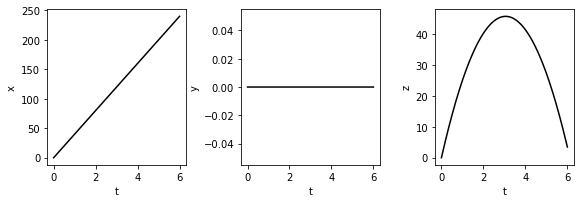

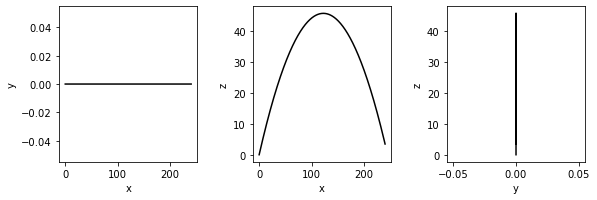

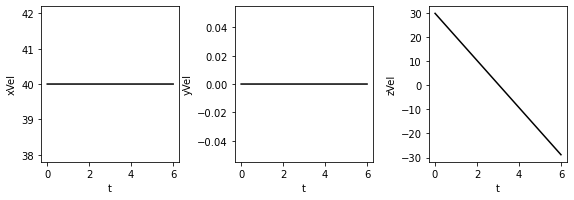

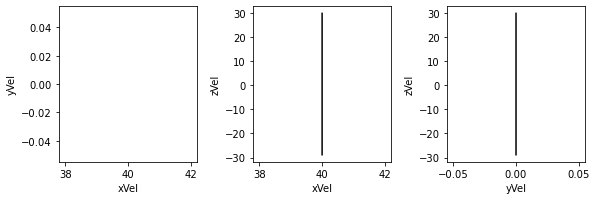

In [48]:
#For comparison, here is a simple idealized ball with no forces due to interaction with air (just gravity), with the same initial
# conditions/speed
p1 = IdealBall(u0 = 40, w0=30, tf = 6.0)   #this is Re = 5.8e5,  50 m/s initial speed
p1.scipy_trajectory()
p1.results()
p1.plot() 

In [49]:
# #creating animation: (only works in pycharm/not juypter..)  showing y and z, for ball traveling in x direction (mainly)

# xvs = p1.xv[:, 0:3]
# xPos = xvs[:,0]
# yPos = xvs[:,1]
# zPos = xvs[:,2]

# dt = 0.001
# L = 40

# fig = plt.figure(figsize=(5, 4))
# ax = fig.add_subplot(autoscale_on=False, xlim=(-L, L), ylim=(-L, L))
# ax.set_aspect('equal')
# ax.grid()

# line, = ax.plot([], [], 'o-', lw=2)
# trace, = ax.plot([], [], ',-', lw=1)
# time_template = 'time = %.1fs'
# time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

# def init():
#     line.set_data([], [])
#     return line,

# def animate(i):
#     thisx = yPos[i]
#     thisy = zPos[i]

#     line.set_data(thisx, thisy)
#     time_text.set_text(time_template % (i*dt))
#     return line, time_text


# ani = animation.FuncAnimation(
#     fig, animate, len(yPos), interval=dt*1000, blit=True)

# plt.show()

Percentage (%) loss in energy from initial to final state for system of soccer ball and air:
-0.1621095279786257


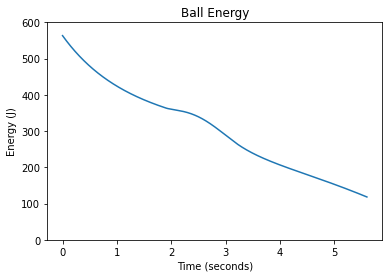

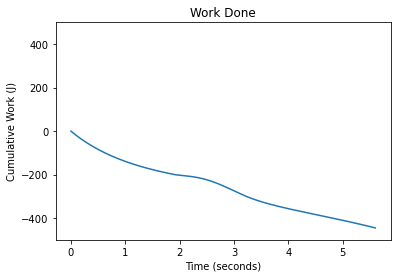

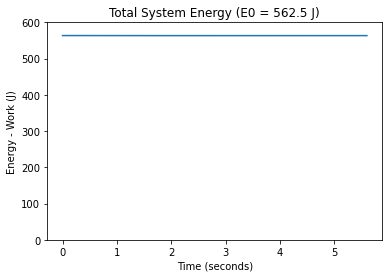

In [100]:
#Testing Conservation of energy::::

vertV = 30    #vertical velocity at point just after being kicked
forwardV = 40  #forward velocity

ball1 = SoccerBall(u0 = forwardV, w0=vertV, tf = 5.6)   #this is Re = 5.8e5,  50 m/s initial speed
vMag = (vertV**2 + forwardV**2)**(0.5)
initialEnergy = 1/2*ball1.m*vMag**2

ball1.RK4_trajectory() #using RK4 trajectory because coded into particle class generation of Forces list with each RK4 steps

endInd1 = int(ball1.tf*(1/ball1.dt))

Pos = ball1.x_RK4
Vel = ball1.v_RK4

r = range(endInd1-2)
workSum = 0.0
workSums = []
Energy = []
g = 9.80665
Gforce = np.array([0,0,-ball1.m*g])

for i in r:
 
    curPos = Pos[i]
    nextPos = Pos[i+1]
    deltaX = nextPos - curPos

    airForce = ball1.Forces[i] - Gforce

    work = np.dot(airForce, deltaX)  #work = F*d  dot product
    workSum = workSum + work
    workSums = np.append(workSums, workSum)

    vMag = vMag = np.linalg.norm(Vel[i])
    KE = 1/2*ball1.m*vMag**2
    PE = ball1.m*g*curPos[2]
    E = KE + PE
    Energy = np.append(Energy, E)

EminusW = Energy - workSums


t1short = ball1.tarray[0:endInd1-2]
plt.figure()
plt.title('Ball Energy');
plt.plot(t1short, Energy)
plt.xlabel('Time (seconds)');
plt.ylabel('Energy (J)');  
plt.ylim([0, 600]);

plt.figure()
plt.title('Work Done');
plt.plot(t1short, workSums)
plt.xlabel('Time (seconds)');
plt.ylabel('Cumulative Work (J)');    
plt.ylim([-500, 500]);

plt.figure()
plt.title('Total System Energy (E0 = 562.5 J)');
plt.plot(t1short,EminusW)
plt.xlabel('Time (seconds)');
plt.ylabel('Energy - Work (J)');  
plt.ylim([0, 600]);


percErr = (initialEnergy-(EminusW[-1]))/(initialEnergy) * 100
print("Percentage (%) loss in energy from initial to final state for system of soccer ball and air:")
print(percErr)


Can see that all 3 Jerk components are zero for this Ideal ball, as there is only constant acceleration of gravity:
0.0
0.0
0.0


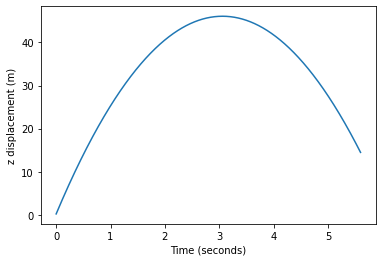

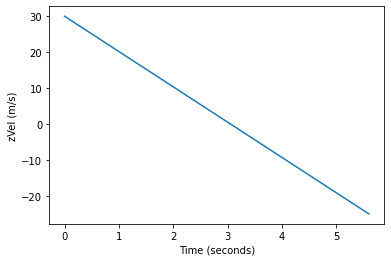

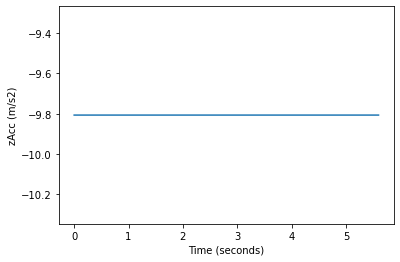

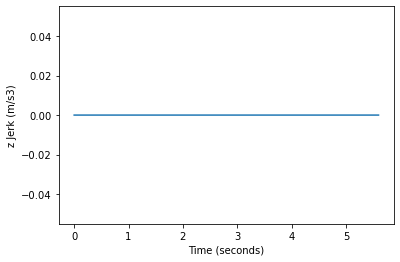

In [7]:
## CALCULATING JERK...use numpy.diff  derivatives magnify error...

#first for simple case of ideal ball, should be zero jerk



vertV = 30    #vertical velocity at point just after being kicked
forwardV = 40  #forward velocity

ball1 = IdealBall(u0 = forwardV, w0=vertV, tf = 5.6)   #this is Re = 5.8e5,  50 m/s initial speed

ball1.RK4_trajectory() #using RK4 trajectory because coded into particle class generation of accelerations list with each RK4 steps

endInd1 = int(ball1.tf*(1/ball1.dt))
time = ball1.tarray
Pos = ball1.x_RK4
Vel = ball1.v_RK4
Acc = ball1.accel
Acc = np.array(Acc) 

xPos = Pos[:,0]
yPos = Pos[:,1]
zPos = Pos[:,2]
xVel = Vel[:,0]
yVel = Vel[:,1]
zVel = Vel[:,2]
xAcc = Acc[:,0]
yAcc = Acc[:,1]
zAcc = Acc[:,2]

xJerk = np.diff(xAcc)/ball1.dt
yJerk = np.diff(yAcc)/ball1.dt
zJerk = np.diff(zAcc)/ball1.dt

t1short = ball1.tarray[0:endInd1-1]
plt.figure()
plt.plot(t1short, zPos)
plt.xlabel('Time (seconds)');
plt.ylabel('z displacement (m)');  

plt.figure()
plt.plot(t1short, zVel)
plt.xlabel('Time (seconds)');
plt.ylabel('zVel (m/s)');  

plt.figure()
plt.plot(t1short, zAcc)
plt.xlabel('Time (seconds)');
plt.ylabel('zAcc (m/s2)');  

t1Jerk = ball1.tarray[0:endInd1-2]
plt.figure()
plt.plot(t1Jerk, zJerk)
plt.xlabel('Time (seconds)');
plt.ylabel('z Jerk (m/s3)');  


print("Can see that all 3 Jerk components are zero for this Ideal ball, as there is only constant acceleration of gravity:")
print(np.mean(xJerk))
print(np.mean(yJerk))  
print(np.mean(zJerk))

Mean Jerk components are all nonzero:
3.5768265143284976
2.84095748577547
6.203127226745699


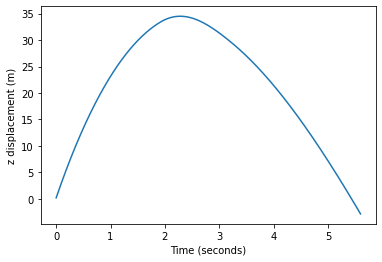

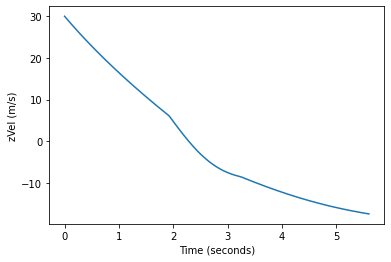

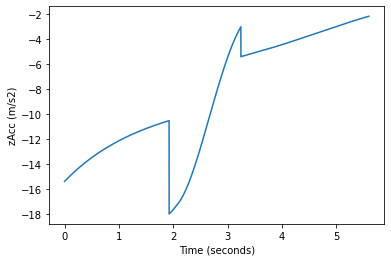

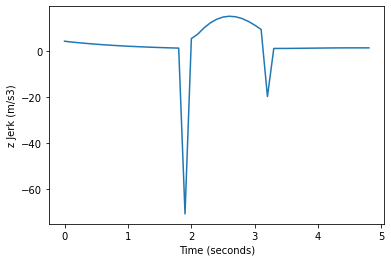

In [8]:
## CALCULATING JERK...use numpy.diff  taking derivative at such a small time step magnifies error and doesn't give reliable results 
# so I am calculating the derivative over a larger time step. 



vertV = 30    #vertical velocity at point just after being kicked
forwardV = 40  #forward velocity

ball1 = SoccerBall(u0 = forwardV, w0=vertV, tf = 5.6)   #this is Re = 5.8e5,  50 m/s initial speed

ball1.RK4_trajectory() #using RK4 trajectory because coded into particle class generation of accelerations list with each RK4 steps

endInd1 = int(ball1.tf*(1/ball1.dt))
time = ball1.tarray
Pos = ball1.x_RK4
Vel = ball1.v_RK4
Acc = ball1.accel
Acc = np.array(Acc) 

xPos = Pos[:,0]
yPos = Pos[:,1]
zPos = Pos[:,2]
xVel = Vel[:,0]
yVel = Vel[:,1]
zVel = Vel[:,2]
xAcc = Acc[:,0]
yAcc = Acc[:,1]
zAcc = Acc[:,2]

xAcc2 = []
yAcc2 = []
zAcc2 = []
t2 = []
r = range(50)
timeStepFactor = 100
for i in r:
    ind = i*timeStepFactor
    xAcc2.append(xAcc[ind])
    yAcc2.append(yAcc[ind])
    zAcc2.append(zAcc[ind])
    tNow = ball1.tarray[ind]
    t2.append(tNow)
    
xJerk2 = np.diff(xAcc2)/(ball1.dt*timeStepFactor)
yJerk2 = np.diff(yAcc2)/(ball1.dt*timeStepFactor)
zJerk2 = np.diff(zAcc2)/(ball1.dt*timeStepFactor)

#calculating with normal time step, not using this
xJerk = np.diff(xAcc)/ball1.dt
yJerk = np.diff(yAcc)/ball1.dt
zJerk = np.diff(zAcc)/ball1.dt

t1short = ball1.tarray[0:endInd1-1]
plt.figure()
plt.plot(t1short, zPos)
plt.xlabel('Time (seconds)');
plt.ylabel('z displacement (m)');  

plt.figure()
plt.plot(t1short, zVel)
plt.xlabel('Time (seconds)');
plt.ylabel('zVel (m/s)');  

plt.figure()
plt.plot(t1short, zAcc)
plt.xlabel('Time (seconds)');
plt.ylabel('zAcc (m/s2)');  


t2short = t2[0:len(t2)-1]
plt.figure()
plt.plot(t2short, zJerk2)
plt.xlabel('Time (seconds)');
plt.ylabel('z Jerk (m/s3)');  

print("Mean Jerk components are all nonzero:")
print(np.mean(np.abs(xJerk2)))
print(np.mean(np.abs(yJerk2)))  
print(np.mean(np.abs(zJerk2)))

In [59]:
#jerk calculation method, cuts off at x=40m or z=0(hits ground)
def calcJerk(ball):
    
    ball.RK4_trajectory() #using RK4 trajectory because coded into particle class generation of accelerations list with each RK4 steps
    
    time = ball.tarray
    Pos = ball.x_RK4
    Vel = ball.v_RK4
    Acc = ball.accel
    Acc = np.array(Acc) 
    
    stopIndGround = 10e10
    stopIndGoal = 10e10
    if ball1.indGround != None:
        stopIndGround = ball1.indGround
    if ball1.indGoal != None:
        stopIndGoal = ball1.indGoal

    if stopIndGround < stopIndGoal:
        stopInd = stopIndGround
    else:
        stopInd = stopIndGoal

    xPos = Pos[0:stopInd,0]
    yPos = Pos[0:stopInd,1]
    zPos = Pos[0:stopInd,2]
    xVel = Vel[0:stopInd,0]
    yVel = Vel[0:stopInd,1]
    zVel = Vel[0:stopInd,2]
    xAcc = Acc[0:stopInd,0]
    yAcc = Acc[0:stopInd,1]
    zAcc = Acc[0:stopInd,2]
    
    xAcc2 = []
    yAcc2 = []
    zAcc2 = []
    t2 = []

    numSteps = 20
    r = range(numSteps)

    timeStepFactor = int(stopInd/numSteps)

    for i in r:
        ind = i*timeStepFactor
        xAcc2.append(xAcc[ind])
        yAcc2.append(yAcc[ind])
        zAcc2.append(zAcc[ind])
        tNow = ball1.tarray[ind]
        t2.append(tNow)
    
    xJerk2 = np.diff(xAcc2)/(ball.dt*timeStepFactor)
    yJerk2 = np.diff(yAcc2)/(ball.dt*timeStepFactor)
    zJerk2 = np.diff(zAcc2)/(ball.dt*timeStepFactor)
    xMean = (np.mean(np.abs(xJerk2)))
    yMean = (np.mean(np.abs(yJerk2)))  
    zMean = (np.mean(np.abs(zJerk2)))
    Jerks = [xMean, yMean, zMean]
    return Jerks

 
#testing:
vertV = 30    #vertical velocity at point just after being kicked
forwardV = 40  #forward velocity

ball5 = SoccerBall(u0 = forwardV, w0=vertV, tf = 5.6)   #this is Re = 5.8e5,  50 m/s initial speed
jerks1 = calcJerk(ball5)
print(np.mean(jerks1))


3.759986034770344


In [91]:
# average Jerk calulator method

def averageJerk(speed):
    angle = 0.5  #radians, ~28.6 degree angle
    vertV = speed*np.sin(angle)    #vertical velocity at point just after being kicked
    forwardV = speed*np.cos(angle)  #forward velocity
    count = 0
    jerks = []
    while count < 100:        
        ball1 = SoccerBall(u0 = forwardV, w0=vertV, tf = 5.6)
        jerk = np.mean(calcJerk(ball1))  #average over three dimensinos
        jerks.append(jerk)
        count = count + 1
        
    avgJerks = np.mean(jerks)
    return avgJerks


In [71]:
print(averageJerk(50))  

1.6259619706168316



	 Position and Velocity at Final Time:
	 Euler:
	 t = 0.00 | r = [0.00, 0.00, 0.00] | v = [26.33, 0.00, 14.38]
	 SciPy ODE Integrator:
	 t = 3.00 r = [47.77, -1.04, 0.00] v = [8.69, -0.21, -13.83]


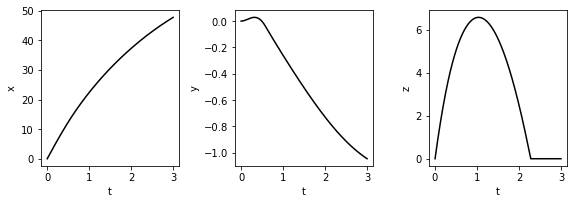

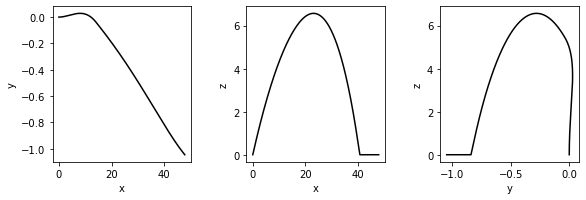

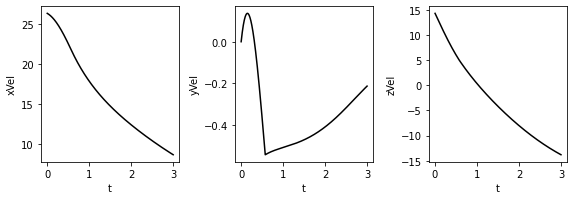

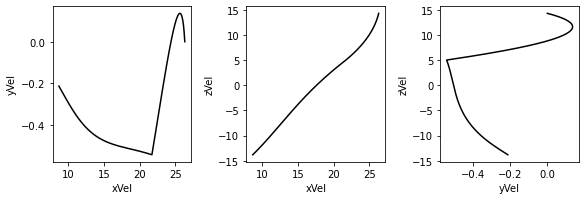

In [36]:
#just testing with different angle/speed...
speed = 30
angle = 0.5  #radians   #seems a realistic shot angle, travels ~40 meters with height of 6 meters
vertV = speed*np.sin(angle)    #vertical velocity at point just after being kicked
forwardV = speed*np.cos(angle)  #forward velocity

p1 = SoccerBall(u0 = forwardV, w0=vertV, tf = 3.0)   #this is Re = 5.8e5,  50 m/s initial speed
p1.scipy_trajectory()
p1.results()
p1.plot()   #zy plot in corner is good to look at knuckles...first plot shows that there's drag so not linear...



In [ ]:
## Looping through to find 'best'/maximizing jerk initial velocity

bestJerk = 0.0
bestSpeed = 0.0
jerks = []

speeds = range(250, 400, 4)  #intervals of 0.3  scaled by 10

for speed in speeds:
    speed = speed/10
    jerk = averageJerk(speed)
    jerks.append(jerk)
    if (jerk > bestJerk):
        bestJerk = jerk
        bestSpeed = speed

best = np.max(jerks)
# print(best)
# print(bestSpeed)
# print(bestJerk)

In [ ]:
## plot results, Jerk vs speed
print(best)
print(bestSpeed)
print(bestJerk)
speeds2 = []
for speed in speeds:
    speeds2.append(speed/10)

plt.figure()
plt.title('Mean Jerk vs Speed, 40 m distance');
plt.plot(speeds2, jerks)
plt.xlabel('Initial Speeds (m/s)');
plt.ylabel('Average Jerk (m/s^3)'); 

In [10]:
#IMPLEMENT cutting off/shortening data to lesser of either indGround or indGoal in calcJerk method...then can say "ideal"
# velocity for shooting from 40 meters out...later can change to be different lengths..

# print(ball1.indGround)
# print(ball1.indGoal)

4.240145270322215


48
Mean Jerk components are all nonzero:
0.711874785643301
0.030223965406864527
2.1212990658556397


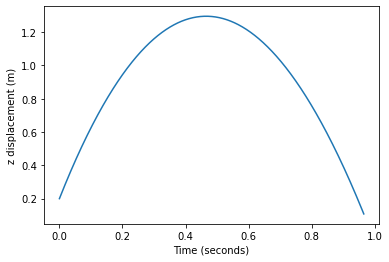

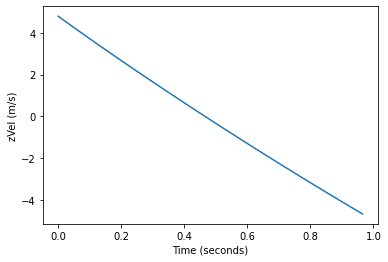

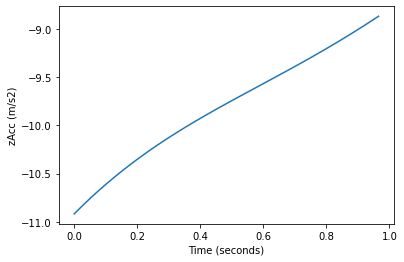

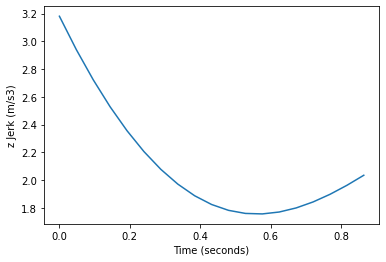

In [37]:
## CALCULATING JERK...use numpy.diff  taking derivative at such a small time step magnifies error and doesn't give reliable results 
# so I am calculating the derivative over a larger time step. 


speed = 10
angle = 0.5  #radians   #seems a realistic shot angle, travels ~40 meters with height of 6 meters
vertV = speed*np.sin(angle)    #vertical velocity at point just after being kicked
forwardV = speed*np.cos(angle)  #forward velocity

ball1 = SoccerBall(u0 = forwardV, w0=vertV, tf = 6.6)   #this is Re = 5.8e5,  50 m/s initial speed

ball1.RK4_trajectory() #using RK4 trajectory because coded into particle class generation of accelerations list with each RK4 steps

endInd1 = int(ball1.tf*(1/ball1.dt))
time = ball1.tarray
Pos = ball1.x_RK4
Vel = ball1.v_RK4
Acc = ball1.accel
Acc = np.array(Acc) 

stopIndGround = 10e10
stopIndGoal = 10e10
if ball1.indGround != None:
    stopIndGround = ball1.indGround
if ball1.indGoal != None:
    stopIndGoal = ball1.indGoal

if stopIndGround < stopIndGoal:
    stopInd = stopIndGround
else:
    stopInd = stopIndGoal

xPos = Pos[0:stopInd,0]
yPos = Pos[0:stopInd,1]
zPos = Pos[0:stopInd,2]
xVel = Vel[0:stopInd,0]
yVel = Vel[0:stopInd,1]
zVel = Vel[0:stopInd,2]
xAcc = Acc[0:stopInd,0]
yAcc = Acc[0:stopInd,1]
zAcc = Acc[0:stopInd,2]

xAcc2 = [] #storing accelerations but at larger intervals
yAcc2 = []
zAcc2 = []
t2 = []

numSteps = 20
r = range(numSteps)

timeStepFactor = int(stopInd/numSteps)
print(timeStepFactor)
for i in r:
    ind = i*timeStepFactor
    xAcc2.append(xAcc[ind])
    yAcc2.append(yAcc[ind])
    zAcc2.append(zAcc[ind])
    tNow = ball1.tarray[ind]
    t2.append(tNow)
    
xJerk2 = np.diff(xAcc2)/(ball1.dt*timeStepFactor)
yJerk2 = np.diff(yAcc2)/(ball1.dt*timeStepFactor)
zJerk2 = np.diff(zAcc2)/(ball1.dt*timeStepFactor)

#calculating with normal time step, not using this
xJerk = np.diff(xAcc)/ball1.dt
yJerk = np.diff(yAcc)/ball1.dt
zJerk = np.diff(zAcc)/ball1.dt

t1short = ball1.tarray[0:stopInd]
plt.figure()
plt.plot(t1short, zPos)
plt.xlabel('Time (seconds)');
plt.ylabel('z displacement (m)');  

plt.figure()
plt.plot(t1short, zVel)
plt.xlabel('Time (seconds)');
plt.ylabel('zVel (m/s)');  

plt.figure()
plt.plot(t1short, zAcc)
plt.xlabel('Time (seconds)');
plt.ylabel('zAcc (m/s2)');  


t2short = t2[0:len(t2)-1]
plt.figure()
plt.plot(t2short, zJerk2)
plt.xlabel('Time (seconds)');
plt.ylabel('z Jerk (m/s3)');  

print("Mean Jerk components are all nonzero:")
print(np.mean(np.abs(xJerk2)))
print(np.mean(np.abs(yJerk2)))  
print(np.mean(np.abs(zJerk2)))

In [ ]:
## testing 'just drag ball'


speed = 30
angle = 0.5  #radians   #seems a realistic shot angle, travels ~40 meters with height of 6 meters
vertV = speed*np.sin(angle)    #vertical velocity at point just after being kicked
forwardV = speed*np.cos(angle)  #forward velocity

ball1 = NoLiftBall(u0 = forwardV, w0=vertV, tf = 6.6)   #this is Re = 5.8e5,  50 m/s initial speed

ball1.RK4_trajectory() #using RK4 trajectory because coded into particle class generation of accelerations list with each RK4 steps

endInd1 = int(ball1.tf*(1/ball1.dt))
time = ball1.tarray
Pos = ball1.x_RK4
Vel = ball1.v_RK4
Acc = ball1.accel
Acc = np.array(Acc) 

stopIndGround = 10e10
stopIndGoal = 10e10
if ball1.indGround != None:
    stopIndGround = ball1.indGround
if ball1.indGoal != None:
    stopIndGoal = ball1.indGoal

if stopIndGround < stopIndGoal:
    stopInd = stopIndGround
else:
    stopInd = stopIndGoal

xPos = Pos[0:stopInd,0]
yPos = Pos[0:stopInd,1]
zPos = Pos[0:stopInd,2]
xVel = Vel[0:stopInd,0]
yVel = Vel[0:stopInd,1]
zVel = Vel[0:stopInd,2]
xAcc = Acc[0:stopInd,0]
yAcc = Acc[0:stopInd,1]
zAcc = Acc[0:stopInd,2]

xAcc2 = [] #storing accelerations but at larger intervals
yAcc2 = []
zAcc2 = []
t2 = []

numSteps = 50
r = range(numSteps)

timeStepFactor = int(stopInd/numSteps)
print(timeStepFactor)
for i in r:
    ind = i*timeStepFactor
    xAcc2.append(xAcc[ind])
    yAcc2.append(yAcc[ind])
    zAcc2.append(zAcc[ind])
    tNow = ball1.tarray[ind]
    t2.append(tNow)
    
xJerk2 = np.diff(xAcc2)/(ball1.dt*timeStepFactor)
yJerk2 = np.diff(yAcc2)/(ball1.dt*timeStepFactor)
zJerk2 = np.diff(zAcc2)/(ball1.dt*timeStepFactor)

#calculating with normal time step, not using this
xJerk = np.diff(xAcc)/ball1.dt
yJerk = np.diff(yAcc)/ball1.dt
zJerk = np.diff(zAcc)/ball1.dt

t1short = ball1.tarray[0:stopInd]
plt.figure()
plt.plot(t1short, zPos)
plt.xlabel('Time (seconds)');
plt.ylabel('z displacement (m)');  

plt.figure()
plt.plot(t1short, zVel)
plt.xlabel('Time (seconds)');
plt.ylabel('zVel (m/s)');  

plt.figure()
plt.plot(t1short, zAcc)
plt.xlabel('Time (seconds)');
plt.ylabel('zAcc (m/s2)');  


t2short = t2[0:len(t2)-1]
plt.figure()
plt.plot(t2short, zJerk2)
plt.xlabel('Time (seconds)');
plt.ylabel('z Jerk (m/s3)');  

print("Mean Jerk components are all nonzero:")
print(np.mean(np.abs(xJerk2)))
print(np.mean(np.abs(yJerk2)))  
print(np.mean(np.abs(zJerk2)))